# library import 

In [2]:
# import package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

#dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

#display images
from torchvision import utils
import matplotlib.pyplot as plt

#utils
import numpy as np
import time
import copy

In [4]:
#데이터 저장 경로 지정
path2data  = 'data'

# 위에서 지정한 파일 경로가 존재하지 않을 경우 새로운 디렉토리 생성
if not os.path.exists(path2data):
    os.mkdir(path2data)
    
#load datasets
train_ds = datasets.STL10  (path2data, split = 'train',download=True, transform = transforms.ToTensor())
val_ds = datasets.STL10(path2data, split = 'test',download=True, transform = transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [5]:
train_ds

Dataset STL10
    Number of datapoints: 5000
    Root location: data
    Split: train
    StandardTransform
Transform: ToTensor()

In [12]:
img, label = train_ds[18]
print(img.shape)
np.mean(img.numpy(), axis=(1,2))


torch.Size([3, 96, 96])


array([0.39389047, 0.3740145 , 0.15717806], dtype=float32)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [19]:
#data normalize
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_ds]
train_stdRGB= [np.std(x.numpy(), axis=(1,2)) for x,_ in train_ds]
print(train_meanRGB[0])
print(train_stdRGB[0])

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([m[0] for m in train_stdRGB])
train_stdG = np.mean([m[1] for m in train_stdRGB])
train_stdB = np.mean([m[2] for m in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in val_ds]
val_stdRGB= [np.std(x.numpy(), axis=(1,2)) for x,_ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])
val_stdR = np.mean([m[0] for m in val_stdRGB])
val_stdG = np.mean([m[1] for m in val_stdRGB])
val_stdB = np.mean([m[2] for m in val_stdRGB])

print(train_meanR,train_meanG,train_meanB)
print(val_meanR,val_meanG,val_meanB)

[0.5199615  0.47785485 0.34138668]
[0.12017056 0.12164892 0.10806711]
0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [ ]:
train_meanRGB.tpye

In [6]:
# dataset에 적용할 transformation을 정의
train_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([train_meanR,train_meanG,train_meanB],[train_stdR,train_stdG,train_stdB]),
    transforms.RandomHorizontalFlip(),
])
val_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([val_meanR,val_meanG,val_meanB],[val_stdR,val_stdG,val_stdB]),
])

In [7]:
#transformation을 dataset에 적용하고, dataloader 생성
train_ds.transform = train_transformation
val_ds.transform = val_transformation

#data loader 생성
train_datalodaer = DataLoader(train_ds, batch_size=32, shuffle = True)
val_datalodaer = DataLoader(val_ds, batch_size=32, shuffle = True)

In [49]:
# a = np.asarray(train_ds[235][0])
# a.shape
train_ds[4999][1]

5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 235 3980  905 2763]


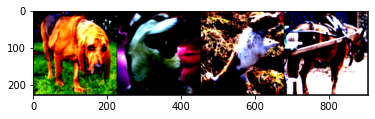

In [31]:
def show(img, y=None, color=True):
    np_img = img.numpy()
    #transpose를 이용해서 원래 이미지의 인덱스의 순열을 바꾸어준다. 
    np_img_tr = np.transpose(np_img,(1,2,0))
    plt.imshow(np_img_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
#0~len(train_ds)까지 grid_size로 정수의 난수 생성
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

#pytorch에서 NN을 사용해서 이미지를 훈련시킬 때 중간중간의 결과가 어떻게
#나오는지 확인하고 싶을 때 사용.(torchvisioni.utils.make_grid)
#https://aigong.tistory.com/183
x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


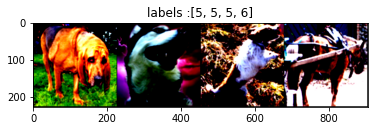

In [9]:
show(x_grid,y_grid)

In [10]:
train_ds[0][0]

tensor([[[ 0.5614,  0.5614,  0.5614,  ...,  0.8413,  0.8413,  0.8413],
         [ 0.5614,  0.5614,  0.5614,  ...,  0.8438,  0.8438,  0.8438],
         [ 0.5614,  0.5614,  0.5614,  ...,  0.8513,  0.8513,  0.8513],
         ...,
         [ 0.3590,  0.3483,  0.3161,  ...,  0.4443,  0.4197,  0.4115],
         [ 0.3665,  0.2926,  0.0708,  ...,  0.4946,  0.4379,  0.4189],
         [ 0.3690,  0.2740, -0.0109,  ...,  0.5114,  0.4439,  0.4214]],

        [[ 0.5462,  0.5462,  0.5462,  ...,  0.8295,  0.8295,  0.8295],
         [ 0.5462,  0.5462,  0.5462,  ...,  0.8269,  0.8269,  0.8269],
         [ 0.5462,  0.5462,  0.5462,  ...,  0.8194,  0.8194,  0.8194],
         ...,
         [ 0.1111,  0.1054,  0.0880,  ...,  0.2575,  0.2141,  0.1997],
         [ 0.1187,  0.0490, -0.1602,  ...,  0.3355,  0.2792,  0.2604],
         [ 0.1213,  0.0302, -0.2430,  ...,  0.3615,  0.3008,  0.2806]],

        [[ 0.1104,  0.1104,  0.1104,  ...,  0.3907,  0.3907,  0.3907],
         [ 0.1104,  0.1104,  0.1104,  ...,  0

In [11]:
torch.cuda.is_available()

True

//현재 사용하고 있는 gpu가 아닌 다른 gpu로 설정해서 사용하고 싶을 경우
os.environ["CUDA_VISIBLE_DEVICES"] = 1
//device = torch.device(f'cuda:{parser.number}' if torch.cuda.is_available() else 'cpu')
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
model.to(device)


## 모델 구축

### resnet 18, 34을 위한 Basic BottleNeck

In [12]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        
        #BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정. 
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride= stride, padding =1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride= stride, padding =1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )
        
        #identity mapping
        # input과  output의 feature map size와 filter 수가 동일한 경우 사용
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        #porjection mapping using 1*1 conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, 
                      stride = stride, bias = False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)    
            )
    def forward(self,x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


### resnet 50,101,152을 위한 BottleNeck

In [13]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size =1, stride= 1, bias =False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size =3, stride=stride, padding=1,bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*BottleNeck.expansion, kernel_size =1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels*BottleNeck.expansion),
        )
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        #porjection mapping using 1*1 conv
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, 
                      stride = stride, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion)    
            )
    def forward(self,x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

## ResNet 구현

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes = 10, init_weights = True):
        super().__init__()
        
        self.in_channels =64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        #각 bottleNeck구조의 첫번째 conv layer에서만 stride=2로 지정하여 크기를 반으로 줄인다.
        # 첫 번째 conv layer이외에 다른 layer에서는 stride를 1로 지정해주기 위해 아래에 
        # _make_layer 함수를 정의해서 사용
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        #weight initialization
        if init_weights:
            self._initialize_weights()
            
    #residual block을 쌓아 ResNet을 구성하는 함수
    def _make_layer(self, block, out_channels, num_blocks, stride):
        #각 bottleNeck구조의 첫번째 conv layer에서만 stride=2로 지정하여 크기를 반으로 줄인다.
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
            
         #layer들을 순차적으로 진행   
        return nn.Sequential(*layers)
            
    def forward(self, x):
        output = self.conv1(x)
        # print(output.shape)
        output = self.conv2_x(output)
        # print(output.shape)
        x= self.conv3_x(output)
        # print(x.shape)
        x= self.conv4_x(x)
        # print(x.shape)
        x= self.conv5_x(x)
        # print(x.shape)
        x= self.avg_pool(x)
        # print(x.shape)
        x= torch.flatten(x,1)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x
    
    # weight 초기화 함수 정의 
    def _initialize_weights(self):
        #모델의 모듈을 차례대로 불러온다.
        for m in self.modules():
            #isinstance() -> 차례로 layer을 입력하여, layer의 형태를 반환(nn.Conv2d, nn.BatchNorm2d ...)
            if isinstance(m,nn.Conv2d):
                # Kaming Initialization
                # 모듈의 가중치를 kaming he normal로 초기화합니다.
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                #torch.nn.init.constant_(tensor, val) -> tensor을 val로 초기화
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

            elif isinstance(m, nn.Linear):
                #torch.nn.init.normal_(tensor, mean=0.0, std=1.0) -> tensor을 mean, std의 normal distrubution으로 초기화
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0) 

# block의 종류, num_block 입력
def resnet18():
    return ResNet(BasicBlock,[2,2,2,2])

def resnet34():
    return ResNet(BasicBlock,[3,4,6,3])

def resnet50():
    return ResNet(BottleNeck,[3,4,6,3])

def resnet101():
    return ResNet(BottleNeck,[3,4,23,3])

def resnet152():
    return ResNet(BottleNeck,[3,8,36,3])

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

#ResNet을 정의해줄 때 첫 번재 layer에 maxpooling layer를 넣어주었기 때문에 
#논문에서와 다르게 56*56사이즈로 출력

cuda:0
torch.Size([3, 10])


In [16]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 손실함수, Optimizer, lr_scheduler 정의

In [1]:
#정답과 예측값의 cross entropy를 한 후 나온 값들의 합을 내서 return해주는 의미
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

#모델의 개선이 없을 경우 learning rate를 조절해 모델의 개선을 유도하는 콜백함수
#https://deep-deep-deep.tistory.com/56
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

NameError: name 'nn' is not defined

In [18]:
#(b[1]-1) : 1의 갯수
b=[3,4,6,3]
a= [2]+ [1]*(b[1]-1)
print(b[0])
print(a)
c = [] 
for i in b:
    c.append([64,64,i])
    

print(c)
    

3
[2, 1, 1, 1]
[[64, 64, 3], [64, 64, 4], [64, 64, 6], [64, 64, 3]]


### 현재 lr을 얻기 위해 계산하는 함수 정의

In [50]:
#현재 lr을 계산하는 함수를 얻기 위해 함수 정의
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

## 배치당 loss와 metric를 계산하는 함수 정의

In [52]:
def metric_batch(output, target):
    #max함수 안의 1 : 어느방향으로 max값을 찾을지를 의미.
    pred = output.argmax(1, keepdim=True)
    #이렇게 나온 값은 (value, index)
    #pred.eq(data)는 pred배열과 data가 일치하느냐를 검사
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

### epoch당 loss를 정의하는 함수

In [51]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    #sanity_check가 true인 경우 1epoch만 학습하고 더이상 학습하지 않는다.
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [ ]:
for i, data in enumerate(dataset_dl):
    for a in range (i):
        inputs = i['img'][a]
        labels = i['label'][a]    
        inputs = inputs.to(device)
        labels = labels.to(device)

In [25]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    #가장 잘 나온 weight를 저장.
    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch+1, num_epochs, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        #epoch마다 loss값과 정확도 값 확인
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
#model.eval() : 해당 모델의 모든 레이어가 evaluation mode에 들어가게 해주는 것. 학습할 때만 필요한 dropout, batchnorm등의 기능을 비황성화 시키는 것.
#torch.no_grad() : gradient계산 context를 비활성화 해주는 역할.    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

        model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

### 하이퍼파라미터 정의

In [26]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_datalodaer,
    'val_dl':val_datalodaer,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'Resnet_weights_pt',
}

#만약 파일이 존재하지 않으면 새로운 파일 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('Resnet_weights_pt')

In [28]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 1/30, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.674932, val loss: 2.201504, accuracy: 26.04, time: 1.5180 min
----------
Epoch 2/30, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.553088, val loss: 1.498867, accuracy: 42.02, time: 2.8950 min
----------
Epoch 3/30, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.477520, val loss: 1.471179, accuracy: 45.95, time: 4.2701 min
----------
Epoch 4/30, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.348669, val loss: 1.379813, accuracy: 48.06, time: 5.5741 min
----------
Epoch 5/30, current lr=0.001
train loss: 1.264249, val loss: 1.604478, accuracy: 45.21, time: 7.0451 min
----------
Epoch 6/30, current lr=0.001
Copied best model weights!
Get best val_loss
train loss: 1.284417, val loss: 1.282689, accuracy: 52.86, time: 8.5477 min
----------
Epoch 7/30, current lr=0.001
train loss: 1.212153, val loss: 1.698436, accuracy

## train loss/val loss & accuracy graph

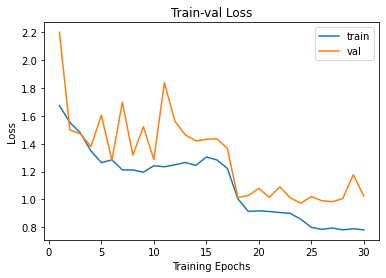

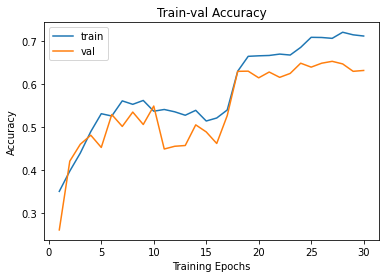

In [29]:
#train/vlaidation progress
num_epochs=params_train["num_epochs"]

#plot loss progress
plt.title("Train-val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"], label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"], label="val")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plot accuracy progress
plt.title("Train-val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"], label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"], label="val")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()